In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# setup latex formatting
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif', size=28)
rc('axes', labelsize=28)

## Inputs

In [53]:
MAX_DIM = 512  # limit images to MAX_DIM x MAX_DIM resolution
MAX_RGB = 255  # maximum RGB intensize

VGG19_INPUT_SHAPE = (224, 224)  # shape of input taken by VV19

content_path = 'images/in/sybil.jpg'  # location of content image
style_path = 'images/in/cezanne_style.jpg'  # location of style image

# for matching features in generated image to content and style images
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

## Preprocessing

In [34]:
def load_img(img_path):
    """ Load image from path into tensor object.
    
    Load image from the specified path into a tensor and resize to
    safely propagate through network.
    
    Args:
        img_path (str): path to image
        
    Returns:
        img (tf.Tensor): tensor representing image with max size
            (1, MAX_DIM, MAX_DIM, 3)
    """
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    # determine scaling to reduce to MAX_DIM
    orig_shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(orig_shape)
    scale = MAX_DIM / long_dim
    # cast into new shape ()
    new_shape = tf.cast(orig_shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]

    return img

In [39]:
def plot_img(ax, img, title=None):
    """ Plot image nicely
    
    Args:
        ax (matplotlib.pyplot.axis): axis to plot image on
        img (tf.Tensor): tensor representing image
        title (str): title for image
    """
    # plot
    img = tf.squeeze(img, axis=0)
    ax.imshow(img)
    # format
    ax.axis('off')
    if title is not None:
        ax.set_title(title)

In [40]:
def load_and_show_content_and_style(content_path, style_path):
    """ Load and display the content and style images
    
    Args:
        content_path (str): path to content image
        style_path (str): path to style image
        
    Returns:
        content_img (numpy.ndarry): RGB array for content image
        style_img (numpy.ndarry): RGB array for style image
    """
    # load
    content_img = load_img(content_path)
    style_img = load_img(style_path)
    # plot
    fig, axs = plt.subplots(1, 2, figsize=(18,9))
    plot_img(axs[0], content_img, 'Content Image')
    plot_img(axs[1], style_img, 'Style Image')
    # format
    fig.tight_layout()
    
    return (content_img, style_img)

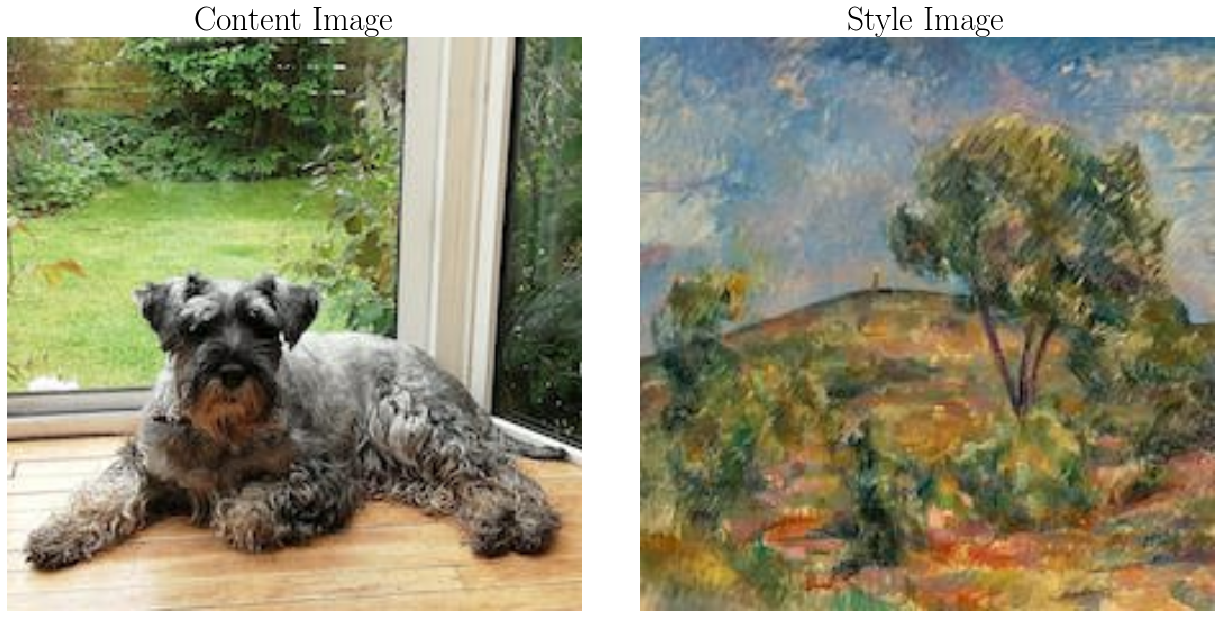

In [41]:
content_img, style_img = load_and_show_content_and_style(content_path, style_path)

## Load pre-trained neural network

In [50]:
# include_top=False -> no classification layer
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

80142336/80134624 [==============================] - 7s 0us/step


In [54]:
def vgg_intermediate_layers(layer_names):
    """ Create pretrained VGG model with intermediate outputs.
    
    Load the pretrained VGG network and construct a model which outputs
    from intermediate layers.
    
    Args:
        layer_names (list): list of layer names to output from.
        
    Returns:
        model (tf.keras.Model): the corresponding model
    """
    # include_top=False -> no classification layer
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [55]:
style_model = vgg_intermediate_layers(style_layers)
style_outputs = style_model(style_img*MAX_RGB)